## Import Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

#from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, PowerTransformer, StandardScaler
from sklearn.feature_extraction import FeatureHasher
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, plot_roc_curve, roc_curve, roc_auc_score, auc

from imblearn.ensemble import BalancedRandomForestClassifier, RUSBoostClassifier, BalancedBaggingClassifier

# Hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

# magic word for producing visualizations in notebook
%matplotlib inline

# and setting the size of all plots.
plt.rcParams['figure.figsize'] = [11, 7]

Using TensorFlow backend.


## Load Dataset

In [2]:
# The C engine doesn't support RegEx so we set it to Python to avoid the warning
census = pd.read_csv('data/census-income.data', header=None, sep=',\s', na_values=['?'], engine='python')

In [3]:
census_columns = [
    'age',
    'class of worker',
    'detailed industry recode',
    'detailed occupation recode',
    'education',
    'wage per hour',
    'enroll in edu inst last wk',
    'marital status',
    'major industry code',
    'major occupation code',
    'race',
    'hispanic origin',
    'sex',
    'member of a labor union',
    'reason for unemployment',
    'full or part time employment stat',
    'capital gains',
    'capital losses',
    'dividends from stocks',
    'tax filer stat',
    'region of previous residence',
    'state of previous residence',
    'detailed household and family stat',
    'detailed household summary in household',
    'instance weight',
    'migration code-change in msa',
    'migration code-change in reg',
    'migration code-move within reg',
    'live in this house 1 year ago',
    'migration prev res in sunbelt',
    'num persons worked for employer',
    'family members under 18',
    'country of birth father',
    'country of birth mother',
    'country of birth self',
    'citizenship',
    'own business or self employed',
    'fill inc questionnaire for veteran\'s admin',
    'veterans benefits',
    'weeks worked in year',
    'year',
    'income class'
]

features_to_drop = ['instance weight']

categorical_features = ['class of worker',
                        'detailed industry recode',
                        'detailed occupation recode',
                        'education',
                        'marital status',
                        'major industry code',
                        'major occupation code',
                        'race',
                        'hispanic origin',
                        'sex',
                        'full or part time employment stat',
                        'tax filer stat',
                        'detailed household and family stat',
                        'detailed household summary in household',
                        'migration code-change in msa',
                        'migration code-change in reg',
                        'migration code-move within reg',
                        'live in this house 1 year ago',
                        'country of birth father',
                        'country of birth mother',
                        'country of birth self',
                        'citizenship',
                        'own business or self employed',
                        'veterans benefits',
                        'enroll in edu inst last wk',
                        'member of a labor union',
                        'reason for unemployment',
                        'region of previous residence',
                        'state of previous residence',
                        'migration prev res in sunbelt',
                        'family members under 18',
                        "fill inc questionnaire for veteran\'s admin",
                        'year']

numerical_features = ['age',
                      'wage per hour',
                      'capital gains',
                      'capital losses',
                      'dividends from stocks',
                      'num persons worked for employer',
                      'weeks worked in year']

census.columns = census_columns
census.head()

,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital status,major industry code,major occupation code,...,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year,income class
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.


In [4]:
census.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199523 entries, 0 to 199522
Data columns (total 42 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   age                                         199523 non-null  int64  
 1   class of worker                             199523 non-null  object 
 2   detailed industry recode                    199523 non-null  int64  
 3   detailed occupation recode                  199523 non-null  int64  
 4   education                                   199523 non-null  object 
 5   wage per hour                               199523 non-null  int64  
 6   enroll in edu inst last wk                  199523 non-null  object 
 7   marital status                              199523 non-null  object 
 8   major industry code                         199523 non-null  object 
 9   major occupation code                       199523 non-null  object 
 

 ## Clean Dataset

In [5]:
def clean_dataset(df):
    # Drop features
    df = df.drop(features_to_drop, axis=1)
    
    # Fill NaN
    df['hispanic origin'] = df['hispanic origin'].fillna('Do not know')
    df['migration code-change in msa'] = df['migration code-change in msa'].fillna('Not identifiable')
    
    df['state of previous residence'] = df['state of previous residence'].fillna('Not in universe')
    df['migration code-change in reg'] = df['migration code-change in reg'].fillna('Not in universe')
    df['migration code-move within reg'] = df['migration code-move within reg'].fillna('Not in universe')
    df['migration prev res in sunbelt'] = df['migration prev res in sunbelt'].fillna('Not in universe')
    
    df['country of birth father'] = df['country of birth father'].fillna(df['country of birth father'].mode()[0])
    df['country of birth mother'] = df['country of birth mother'].fillna(df['country of birth mother'].mode()[0])
    df['country of birth self'] = df['country of birth self'].fillna(df['country of birth self'].mode()[0])
    
    df[categorical_features] = df[categorical_features].astype(str)
    
    # Encode income class column
    df['income class'] = df['income class'].map({'- 50000.': 0, '50000+.': 1})

    return df

In [6]:
census = clean_dataset(census)
census.head()

,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital status,major industry code,major occupation code,...,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year,income class
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,0
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,0
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,0
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,0
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,0


In [7]:
census.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199523 entries, 0 to 199522
Data columns (total 41 columns):
 #   Column                                      Non-Null Count   Dtype 
---  ------                                      --------------   ----- 
 0   age                                         199523 non-null  int64 
 1   class of worker                             199523 non-null  object
 2   detailed industry recode                    199523 non-null  object
 3   detailed occupation recode                  199523 non-null  object
 4   education                                   199523 non-null  object
 5   wage per hour                               199523 non-null  int64 
 6   enroll in edu inst last wk                  199523 non-null  object
 7   marital status                              199523 non-null  object
 8   major industry code                         199523 non-null  object
 9   major occupation code                       199523 non-null  object
 10  race    

## Split train and validation sets

In [8]:
X = census.drop('income class', axis=1)
y = census['income class']

In [9]:
y.mean()

0.06205800834991455

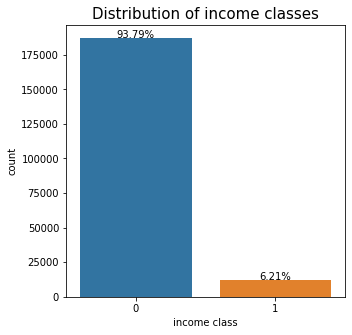

In [10]:
plt.figure(figsize=(5, 5))
total = census.shape[0]
ax = sns.countplot(x="income class", data=census)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.,
            height + 3,
            '{0:.2%}'.format(height/total),
            ha="center")
plt.title('Distribution of income classes', fontsize=15)
plt.show()

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=666)

## Bayesian Hyperparameter Tuning with Hyperopt

In [15]:
# Scoring and optimization functions
def objective_rus(params):
    print("Training with params: ")
    print(params)
    
    model = RUSBoostClassifier(n_estimators=int(params['n_estimators']), 
                               learning_rate=params['learning_rate'], 
                               random_state=666)
   
    # The score function should return the loss (1-score)
    # since the optimize function looks for the minimum
    best_score = cross_val_score(model, X_tr, y, scoring='roc_auc', cv=2, n_jobs=5).mean()
    loss = 1 - best_score
    
    return {'loss': loss, 'status': STATUS_OK}

In [19]:
# Set up space dictionary with specified hyperparameters
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 1000, 1),
    'learning_rate': hp.quniform('eta', 0.025, 1, 0.025),
}

### Simple Pipeline

In [14]:
preprocessor = make_column_transformer(
    (Pipeline([
        ('num', SimpleImputer()),
        ('sc', StandardScaler()),
    ]), numerical_features),
    (Pipeline([
        ('num', SimpleImputer(strategy='constant', fill_value='Unknown')),
        ( 'enc', OneHotEncoder(categories='auto', sparse = False, handle_unknown='ignore' ))
    ]), categorical_features),
    remainder='drop'
)

pipeline = Pipeline([
    ('pre', preprocessor)
])

In [15]:
X_tr = pipeline.fit_transform(X)

In [17]:
# Run the algorithm
best = fmin(fn=objective_rus,space=space, max_evals=20, rstate=np.random.RandomState(666), algo=tpe.suggest)
best

Training with params:                                                                    
{'learning_rate': 0.7250000000000001, 'n_estimators': 577.0}                             
Training with params:                                                                    
{'learning_rate': 0.225, 'n_estimators': 614.0}                                          
Training with params:                                                                    
{'learning_rate': 0.15000000000000002, 'n_estimators': 886.0}                            
Training with params:                                                                    
{'learning_rate': 0.4, 'n_estimators': 80.0}                                             
Training with params:                                                                    
{'learning_rate': 0.05, 'n_estimators': 56.0}                                            
Training with params:                                                                    
{'learning

{'eta': 0.15000000000000002, 'n_estimators': 886.0}

Adapt the pipeline with the best parameters

In [18]:
preprocessor = make_column_transformer(
    (Pipeline([
        ('num', SimpleImputer()),
        ('sc', StandardScaler()),
    ]), numerical_features),
    (Pipeline([
        ('num', SimpleImputer(strategy='constant', fill_value='Unknown')),
        ( 'enc', OneHotEncoder(categories='auto', sparse = False, handle_unknown='ignore' ))
    ]), categorical_features),
    remainder='drop'
)

simple_pipeline = Pipeline([
    ('pre', preprocessor),
    ('clf', RUSBoostClassifier(n_estimators=886, learning_rate=0.15, random_state=666))
])

In [20]:
simple_pipeline.fit(X_train, y_train);
y_pred = simple_pipeline.predict(X_val)

print(classification_report(y_val, y_pred))
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

print("AUC: %s" % auc(fpr, tpr))

              precision    recall  f1-score   support

           0       0.99      0.86      0.92     37429
           1       0.29      0.90      0.44      2476

    accuracy                           0.86     39905
   macro avg       0.64      0.88      0.68     39905
weighted avg       0.95      0.86      0.89     39905

AUC: 0.8758552110142753


### SelectKBest

In [16]:
preprocessor = make_column_transformer(
    (Pipeline([
        ('num', SimpleImputer()),
        ('sc', StandardScaler()),
    ]), numerical_features),
    (Pipeline([
        ('num', SimpleImputer(strategy='constant', fill_value='Unknown')),
        ( 'enc', OneHotEncoder(categories='auto', sparse = False, handle_unknown='ignore' ))
    ]), categorical_features),
    remainder='drop'
)

pipeline = Pipeline([
    ('pre', preprocessor),
    ('sel', SelectKBest(k=94))
])

In [17]:
X_tr = pipeline.fit_transform(X, y)

In [20]:
# Run the algorithm
best = fmin(fn=objective_rus,space=space, max_evals=100, rstate=np.random.RandomState(666), algo=tpe.suggest)
best

Training with params:                                                                    
{'learning_rate': 0.7250000000000001, 'n_estimators': 577.0}                             
Training with params:                                                                    
{'learning_rate': 0.225, 'n_estimators': 614.0}                                          
Training with params:                                                                    
{'learning_rate': 0.15000000000000002, 'n_estimators': 886.0}                            
Training with params:                                                                    
{'learning_rate': 0.4, 'n_estimators': 80.0}                                             
Training with params:                                                                    
{'learning_rate': 0.05, 'n_estimators': 56.0}                                            
Training with params:                                                                    
{'learning

{'learning_rate': 0.775, 'n_estimators': 631.0}                                          
Training with params:                                                                    
{'learning_rate': 0.025, 'n_estimators': 801.0}                                          
Training with params:                                                                    
{'learning_rate': 0.9500000000000001, 'n_estimators': 908.0}                             
Training with params:                                                                    
{'learning_rate': 0.15000000000000002, 'n_estimators': 716.0}                            
Training with params:                                                                    
{'learning_rate': 0.07500000000000001, 'n_estimators': 523.0}                            
Training with params:                                                                    
{'learning_rate': 0.375, 'n_estimators': 400.0}                                          
Training w

Training with params:                                                                    
{'learning_rate': 0.525, 'n_estimators': 841.0}                                          
Training with params:                                                                    
{'learning_rate': 0.375, 'n_estimators': 810.0}                                          
Training with params:                                                                    
{'learning_rate': 0.6000000000000001, 'n_estimators': 249.0}                             
Training with params:                                                                    
{'learning_rate': 0.25, 'n_estimators': 774.0}                                           
Training with params:                                                                    
{'learning_rate': 0.125, 'n_estimators': 948.0}                                          
Training with params:                                                                    
{'learning

{'eta': 0.1, 'n_estimators': 997.0}

In [21]:
preprocessor = make_column_transformer(
    (Pipeline([
        ('num', SimpleImputer()),
        ('sc', StandardScaler()),
    ]), numerical_features),
    (Pipeline([
        ('num', SimpleImputer(strategy='constant', fill_value='Unknown')),
        ( 'enc', OneHotEncoder(categories='auto', sparse = False, handle_unknown='ignore' ))
    ]), categorical_features),
    remainder='drop'
)

selectKBest_model = Pipeline([
    ('pre', preprocessor),
    ('sel', SelectKBest(k=94)),
    #('clf', RUSBoostClassifier(n_estimators=886, learning_rate=0.15, random_state=666))
    ('clf', RUSBoostClassifier(n_estimators=997, learning_rate=0.1, random_state=666))
])

In [22]:
selectKBest_model.fit(X_train, y_train);
y_pred = selectKBest_model.predict(X_val)

print(classification_report(y_val, y_pred))
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

print("AUC: %s" % auc(fpr, tpr))

              precision    recall  f1-score   support

           0       0.99      0.85      0.92     37429
           1       0.29      0.89      0.43      2476

    accuracy                           0.86     39905
   macro avg       0.64      0.87      0.68     39905
weighted avg       0.95      0.86      0.89     39905

AUC: 0.8733257530865871


### PCA

In [37]:
preprocessor = make_column_transformer(
    (Pipeline([
        ('num', SimpleImputer()),
        ('sc', StandardScaler()),
    ]), numerical_features),
    (Pipeline([
        ('num', SimpleImputer(strategy='constant', fill_value='Unknown')),
        ( 'enc', OneHotEncoder(categories='auto', sparse = False, handle_unknown='ignore' ))
    ]), categorical_features),
    remainder='drop'
)

pipeline = Pipeline([
    ('pre', preprocessor),
    ('pca', PCA(n_components=81, random_state=666))
])

In [38]:
X_tr = pipeline.fit_transform(X)

In [80]:
# Run the algorithm
best = fmin(fn=objective_rus,space=space, max_evals=20, rstate=np.random.RandomState(666), algo=tpe.suggest)
best

Training with params:                                                                    
{'learning_rate': 0.7250000000000001, 'n_estimators': 577.0}                             
Training with params:                                                                    
{'learning_rate': 0.225, 'n_estimators': 614.0}                                          
Training with params:                                                                    
{'learning_rate': 0.15000000000000002, 'n_estimators': 886.0}                            
Training with params:                                                                    
{'learning_rate': 0.4, 'n_estimators': 80.0}                                             
Training with params:                                                                    
{'learning_rate': 0.05, 'n_estimators': 56.0}                                            
Training with params:                                                                    
{'learning

{'eta': 0.125, 'n_estimators': 685.0}

In [32]:
preprocessor = make_column_transformer(
    (Pipeline([
        ('num', SimpleImputer()),
        ('sc', StandardScaler()),
    ]), numerical_features),
    (Pipeline([
        ('num', SimpleImputer(strategy='constant', fill_value='Unknown')),
        ( 'enc', OneHotEncoder(categories='auto', sparse = False, handle_unknown='ignore' ))
    ]), categorical_features),
    remainder='drop'
)

pca_model = Pipeline([
    ('pre', preprocessor),
    ('pca', PCA(n_components=81, random_state=666)),
    ('clf', RUSBoostClassifier(n_estimators=685, learning_rate=0.125, random_state=666))
])

In [33]:
pca_model.fit(X_train, y_train);
y_pred = pca_model.predict(X_val)

print(classification_report(y_val, y_pred))
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

print("AUC: %s" % auc(fpr, tpr))

              precision    recall  f1-score   support

           0       0.99      0.85      0.92     37429
           1       0.28      0.88      0.43      2476

    accuracy                           0.85     39905
   macro avg       0.64      0.87      0.67     39905
weighted avg       0.95      0.85      0.88     39905

AUC: 0.8659152551232056


## Test

### Load Dataset

In [23]:
# The C engine doesn't support RegEx so we set it to Python to avoid the warning
census_test = pd.read_csv('data/census-income.test', header=None, sep=',\s', na_values=['?'], engine='python')

In [24]:
census_test.columns = census_columns
census_test.head()

,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital status,major industry code,major occupation code,...,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year,income class
0,38,Private,6,36,1st 2nd 3rd or 4th grade,0,Not in universe,Married-civilian spouse present,Manufacturing-durable goods,Machine operators assmblrs & inspctrs,...,Mexico,Mexico,Mexico,Foreign born- Not a citizen of U S,0,Not in universe,2,12,95,- 50000.
1,44,Self-employed-not incorporated,37,12,Associates degree-occup /vocational,0,Not in universe,Married-civilian spouse present,Business and repair services,Professional specialty,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,26,95,- 50000.
2,2,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,95,- 50000.
3,35,Private,29,3,High school graduate,0,Not in universe,Divorced,Transportation,Executive admin and managerial,...,United-States,United-States,United-States,Native- Born in the United States,2,Not in universe,2,52,94,- 50000.
4,49,Private,4,34,High school graduate,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,50,95,- 50000.


### Clean Dataset

In [25]:
census_test = clean_dataset(census_test)
census_test.head()

,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital status,major industry code,major occupation code,...,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year,income class
0,38,Private,6,36,1st 2nd 3rd or 4th grade,0,Not in universe,Married-civilian spouse present,Manufacturing-durable goods,Machine operators assmblrs & inspctrs,...,Mexico,Mexico,Mexico,Foreign born- Not a citizen of U S,0,Not in universe,2,12,95,0
1,44,Self-employed-not incorporated,37,12,Associates degree-occup /vocational,0,Not in universe,Married-civilian spouse present,Business and repair services,Professional specialty,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,26,95,0
2,2,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,95,0
3,35,Private,29,3,High school graduate,0,Not in universe,Divorced,Transportation,Executive admin and managerial,...,United-States,United-States,United-States,Native- Born in the United States,2,Not in universe,2,52,94,0
4,49,Private,4,34,High school graduate,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,50,95,0


In [26]:
census_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99762 entries, 0 to 99761
Data columns (total 41 columns):
 #   Column                                      Non-Null Count  Dtype 
---  ------                                      --------------  ----- 
 0   age                                         99762 non-null  int64 
 1   class of worker                             99762 non-null  object
 2   detailed industry recode                    99762 non-null  object
 3   detailed occupation recode                  99762 non-null  object
 4   education                                   99762 non-null  object
 5   wage per hour                               99762 non-null  int64 
 6   enroll in edu inst last wk                  99762 non-null  object
 7   marital status                              99762 non-null  object
 8   major industry code                         99762 non-null  object
 9   major occupation code                       99762 non-null  object
 10  race                  

### Predictions

In [27]:
X_test = census_test.drop('income class', axis=1)
y_test = census_test['income class']

#### Simple pipeline

In [44]:
y_pred_test = simple_pipeline.predict(X_test)

print(classification_report(y_test, y_pred_test))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)

print("AUC: %s" % auc(fpr, tpr))

              precision    recall  f1-score   support

           0       0.99      0.86      0.92     93576
           1       0.29      0.90      0.44      6186

    accuracy                           0.86     99762
   macro avg       0.64      0.88      0.68     99762
weighted avg       0.95      0.86      0.89     99762

AUC: 0.8779499821179911


In [46]:
submission = pd.DataFrame(y_pred_test).astype(float)
submission.columns = ['income class']
submission.reset_index(inplace=True)
submission.to_csv('temp/RUSBoostClassifier.csv', index=False)

#### SelectKBest

In [28]:
y_pred_test = selectKBest_model.predict(X_test)

print(classification_report(y_test, y_pred_test))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)

print("AUC: %s" % auc(fpr, tpr))

              precision    recall  f1-score   support

           0       0.99      0.85      0.92     93576
           1       0.29      0.89      0.43      6186

    accuracy                           0.86     99762
   macro avg       0.64      0.87      0.68     99762
weighted avg       0.95      0.86      0.89     99762

AUC: 0.8735774930310748


In [47]:
submission = pd.DataFrame(y_pred_test).astype(float)
submission.columns = ['income class']
submission.reset_index(inplace=True)
submission.to_csv('temp/RUSBoostClassifier with SelectKBest.csv', index=False)

#### PCA

In [48]:
y_pred_test = pca_model.predict(X_test)

print(classification_report(y_test, y_pred_test))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)

print("AUC: %s" % auc(fpr, tpr))

              precision    recall  f1-score   support

           0       0.99      0.85      0.92     93576
           1       0.28      0.89      0.43      6186

    accuracy                           0.85     99762
   macro avg       0.64      0.87      0.67     99762
weighted avg       0.95      0.85      0.89     99762

AUC: 0.8702789972757818


In [49]:
submission = pd.DataFrame(y_pred_test).astype(float)
submission.columns = ['income class']
submission.reset_index(inplace=True)
submission.to_csv('temp/RUSBoostClassifier with PCA.csv', index=False)